# Preprocesamiento de los datos y Análisis Descriptivo

**Autor**: *Jorge Díaz Rosique*

**Fecha**: 17/12/2022

**Descripción**: Carga los conjuntos de datos generados a través de las trazas, los preprocesa para trabajar con ellos y se obtienen algunas primeras conclusiones y resultados.

**Revisiones**:
* Revisión 0.01 - Archivo creado

In [ ]:
#### Instalación de algunas librerias ####
!pip install seaborn==0.12.1
!pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 288 kB 27.3 MB/s 
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#### Importación de liberías ####

# Librerías para realizar el preprocesamiento básico y cargar y guardar datos
import os
import numpy as np
import pandas as pd
import copy
from sklearn import preprocessing

# Librerías para la representación gráfica
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

#GDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, files
from oauth2client.client import GoogleCredentials

# Carga y preproceso de los datos

Este apartado tiene como objetivo obtener un `dataset` preparado para la posterior extracción de información del mismo. Para ello, este se dividirá en dos partes bien diferenciadas. Por un lado se cargarán los datos, realizando todos los preliminares necesarios para ellos. Posteriormente, en segundo lugar,
se preprocesarán para cumplir con el objetivo propuesto.

## Preliminares

Para la correcta carga de los datos, es necesario realizar algunos pasos técnicos. En este caso, puesto que la información se encuentra en Google Drive, se necesitará montar para poder acceder a él.

In [ ]:
# Autentificación de Drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Montar drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Se comprueba que esta montado con el siguiente comando de consola
!ls -l -h

total 8.0K
drwx------ 6 root root 4.0K Dec 23 21:20 drive
drwxr-xr-x 1 root root 4.0K Dec 20 20:19 sample_data


Visto esto, también se dispondrá de una lista con los nombres de los diferentes ficheros a cargar y procesar.

In [ ]:
#### Definición de listas con los ficheros ####

# Lista de nombres
benchmarks = ['aes_128', 'bitcount1', 'bitcount2', 'bubblesort', 'crc_32_short',
              'fir_short', 'heapsort', 'insertsort', 'maddconst', 'mmult',
              'mmultconst', 'mmultvector', 'quicksort', 'sha_short', 'tarai']

# Lista de .csv
benchmarks_csv = [bench + '.csv' for bench in benchmarks]

## Carga de datos

Principalmente, se utilizará lo poco visto hasta el momento junto a `pandas` para la carga de datos.

Para actuar de forma óptima, sería conveniente cargar un conjunto de datos para comenzar a observar su estructura antes de cargarlo todo de golpe. Sin embargo, es necesario recordar que estos conjuntos de datos han sido generados por el código mostrado en **Create_Dataset_004.ipynb**.

Por lo tanto, conociendo ya la estructura, se cargarán los diferentes conjuntos en un solo `DataFrame` de `pandas`. Gracias a que la columna `bench` de cada archivo `.csv`contiene información sobre el benchmark al que corresponde dicha información, luego se podrá trabajar por se parado si se requiere.

In [ ]:
#### Carga de datos ####

# Ruta de los ficheros
route = '/content/drive/MyDrive/ML4FT/data/datasets/'

# Carga y unión de los datos
first = True

for csv in benchmarks_csv:
    if first:
        data = pd.read_csv(route + csv, sep = ';')
        first = False
    else:
        temp = pd.read_csv(route + csv, sep = ';')
        data = pd.concat([data, temp])

Tras esto, se puede mostrar la información del conjunto cargado.

In [ ]:
# Información del dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10896 entries, 0 to 1355
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bench              10896 non-null  object 
 1   ind                10896 non-null  object 
 2   r0                 10896 non-null  int64  
 3   r1                 10896 non-null  int64  
 4   r2                 10896 non-null  int64  
 5   r3                 10896 non-null  int64  
 6   r4                 10896 non-null  int64  
 7   r5                 10896 non-null  int64  
 8   r6                 10896 non-null  int64  
 9   r7                 10896 non-null  int64  
 10  r8                 10896 non-null  int64  
 11  r9                 10896 non-null  int64  
 12  sl                 10896 non-null  int64  
 13  fp                 10896 non-null  int64  
 14  ip                 10896 non-null  int64  
 15  sp                 10896 non-null  int64  
 16  lr                 1089

Se observa como se ha cargado correctamente. El conjunto contiene $10896$ entradas y $32$ columnas. Estas últimas contienen la siguiente información:
* `bench`: Benchmark al que corresponde el individuo.
* `ind`: Individuo sobre el que se han extraído los diferentes datos.
* `ri`: Dieciséis columnas correspondientes a los dieciséis registros del procesador.
* `totalInstructions`: Número total de instrucciones ejecutadas. También corresponde al último instante del programa.
* `memoryRead`: Número de instrucciones que han leído de la memoria.
* `memoryWrite`: Número de instrucciones que han escrito sobre la memoria.
* `memoryAccess`: Número de instrucciones que han accedido la memoria.
* `text`: Tamaño del texto.
* `data`: Tamaño de los datos.
* `bss`: Tamaño del bss.
* `stack`: Tamaño del stack.
* `rf_sdc`: Tasa $SDC$ media de cada uno de los registros.
* `rf_hang`: Tasa $HANG$ media de cada uno de los registros.
* `size`: Tamaño del individuo.
* `cycles`: Número de ciclos.
* `ft_overall`: Tasa $unACE$ general del programa.
* `sdc_overall`: Tasa $SDC$ general del programa.
* `hang_overall`: Tasa $HANG$ general del programa.

## Preproceso de datos

Debido a la propia obtención de estos conjuntos, esta tarea se simplifica en gran medida, ya que los datos se encuentran tal y como se han requerido. Sin embargo, es necesario hacer algunas transformaciones.

Debido a que este trabajo se centra en los tiempos de vida de los registros y los soft errors que sucenden en ellos, no se tendrán en cuenta las tasas de error *overall*. Es decir, aquellas que abarcan también errores en la memoria y no solo en los registros. También se eliminará la variable `stack` ya que no proporciona información alguna.

In [ ]:
# Copia de los datos para no trabajar con los originales
datos = data.copy()

In [ ]:
#### Eliminación de columnas innecesarias ####

# Uso de .drop
datos.drop(['ft_overall','sdc_overall','hang_overall','stack'], axis=1, inplace=True)

# Reinicio de los indicies
datos.reset_index(drop = True, inplace = True)

In [ ]:
# Información del dataset
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10896 entries, 0 to 10895
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bench              10896 non-null  object 
 1   ind                10896 non-null  object 
 2   r0                 10896 non-null  int64  
 3   r1                 10896 non-null  int64  
 4   r2                 10896 non-null  int64  
 5   r3                 10896 non-null  int64  
 6   r4                 10896 non-null  int64  
 7   r5                 10896 non-null  int64  
 8   r6                 10896 non-null  int64  
 9   r7                 10896 non-null  int64  
 10  r8                 10896 non-null  int64  
 11  r9                 10896 non-null  int64  
 12  sl                 10896 non-null  int64  
 13  fp                 10896 non-null  int64  
 14  ip                 10896 non-null  int64  
 15  sp                 10896 non-null  int64  
 16  lr                 108

Tras esto se procederá a estudiar los valores a típicos para un mejor entendimiento de los datos. Por eso mismo, a continuación se observará la distribución de las variables dependientes para cada uno de los benchmarks. Para ello, se definirán dos funciones. Una encargada de realizar los boxplot para el análisis y otra para la limpieza de los datos.

In [ ]:
# Se define la paleta de colores

palette_gray = sns.color_palette("Greys", n_colors = 17)
palette_gray = palette_gray.as_hex()[5:13] + palette_gray.as_hex()[5:12][::-1]

In [ ]:
# Función Boxplot Tasa Soft Errors
def boxplot_tasa(datos, tasa, atipicos = False):
    titulo = 'Boxplot para Tasa ' + tasa + ' (Sin atípicos)' if atipicos else 'Boxplot para Tasa ' + tasa
    plt.figure(figsize = (16,7))
    sns.boxplot(x='bench',y = 'rf_' + tasa, data = datos, palette = palette_gray)

    # Personalización
    plt.xlabel('Benchmark', fontsize = 12)
    plt.ylabel('Tasa ' + tasa, fontsize = 12)
    plt.title(titulo, fontsize=14)

    plt.show()

Ahora bien, se procederá a eliminar dichos datos anómalos usando el recorrido intercuartílico. Es decir, calcular para cada algoritmo $$IQR = Q_3 - Q_1,$$ obtener el intervalo $$[Q_1-1'5*IQR,Q_3+1'5*IQR]$$ y descartar a todo individuo que no este contenido por el mismo.

Destacar que, es posible que no se eliminen todos o, por otro lado, que se eliminen más de los necesarios. Pero con este criterio se asegura la obtención de una mejor estructura para el conjunto de datos.

In [ ]:
#### Eliminación de valores atípicos ####

def limpiar_atipicos(datos,tasa):
    # Se crea una lista donde se guardarán los diferentes bench limpios
    datos_clean_list = []

    # Bucle que elimina los valores atípicos
    for bench in benchmarks:
        # Calculo de IQR
        datos_q1 = datos['rf_' + tasa][datos['bench'] == bench].quantile(0.25)
        datos_q3 = datos['rf_' + tasa][datos['bench'] == bench].quantile(0.75)
        datos_iqr = datos_q3 - datos_q1

        # Filtrado de datos
        bench_clean = datos[(datos['rf_' + tasa]>(datos_q1-1.5*datos_iqr))&
                      (datos['rf_' + tasa]<(datos_q3+1.5*datos_iqr))&
                      (datos['bench'] == bench)]

        # Se añade a la lista
        datos_clean_list.append(bench_clean)

    # Se guarda en la misma variable anterior, ya que no usaremos esos datos
    datos_clean = pd.concat(datos_clean_list)
    datos_clean.reset_index(drop=True, inplace = True)
    
    return datos_clean

In [ ]:
# Se aplica la función de atípicos sobre los datos
datos_sdc_clean = limpiar_atipicos(datos,'sdc')
datos_hang_clean = limpiar_atipicos(datos,'hang')

### Tasa SDC

Se realizará el estudio primero para la Tasa SDC.

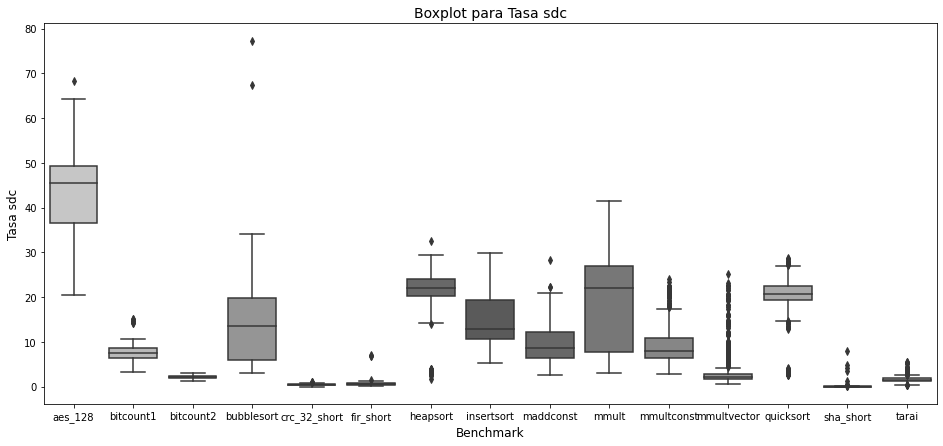

In [ ]:
# Se muestra el boxplot
boxplot_tasa(datos,'sdc')

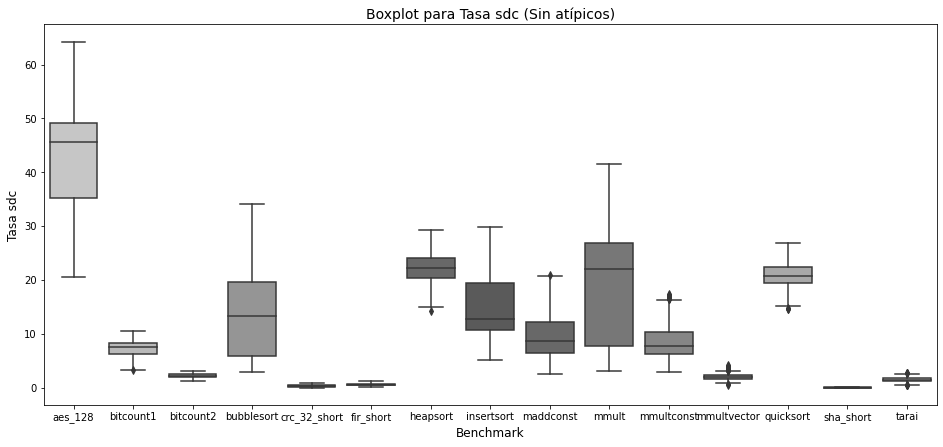

In [ ]:
# Se muestra el boxplot sin atípicos
boxplot_tasa(datos_sdc_clean,'sdc',atipicos=True)

### Tasa HANG

Repetición del estudio para la Tasa HANG.

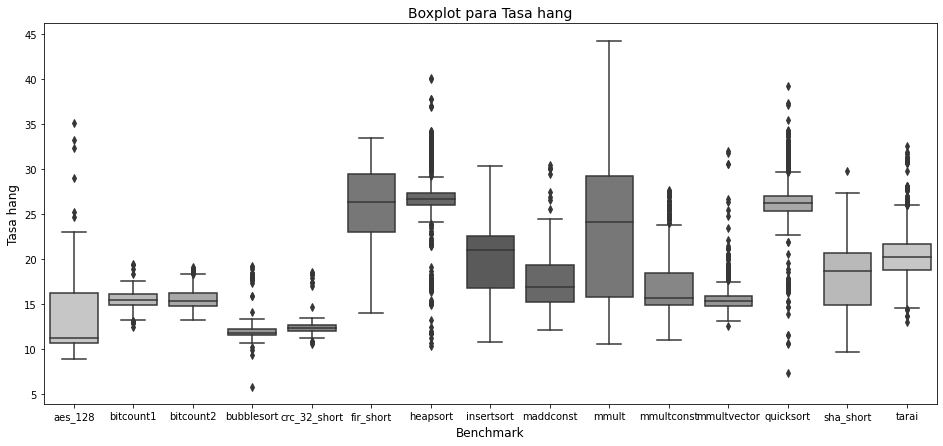

In [ ]:
# Se muestra el boxplot
boxplot_tasa(datos,'hang')

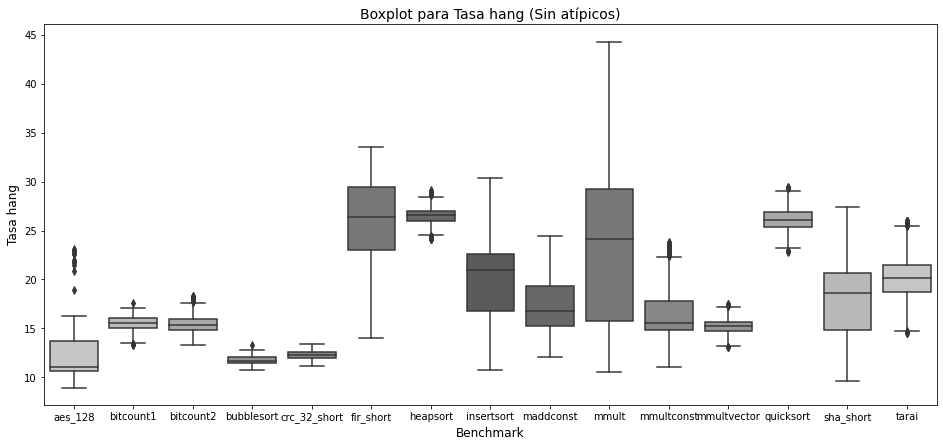

In [ ]:
# Se muestra el boxplot sin atípicos
boxplot_tasa(datos_hang_clean,'hang',atipicos=True)

Tras el análisis de los valores atípicos para ambas tasas, es el momento de una última consideración en este apartado. Es necesario recordar que se está trabajando con algoritmos cuya ejecución puede diferir mucho entre el resto. Por ejemplo, la multiplicación de matrices `mmult`es bastante diferente al conteo de bits de `bitcount1` o `bitcount2`. Esto implica que los lifetimes de los registros no puedan compararse entre diferentes algoritmos.

In [ ]:
# Maximo de los LT por benchmark
lifetimes_max = datos[['bench','r0','r1','r2','r3','r4','r5','r6','r7','r8','r9','sl','fp','ip','sp','lr']].groupby('bench').max()
lifetimes_max = lifetimes_max.reset_index(drop=False)

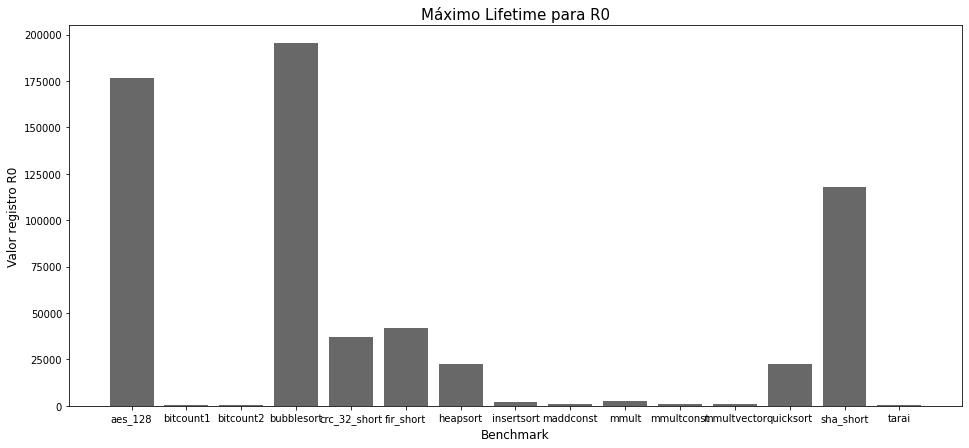

In [ ]:
# Definimos el tamaño de la figura y plotemos el grafico de barras
plt.figure(figsize=(16, 7))
plt.bar(lifetimes_max['bench'],lifetimes_max['r0'], color = palette_gray[6])

# Añadimos los ejes y el título
plt.xlabel('Benchmark', fontsize = 12)
plt.ylabel('Valor registro R0', fontsize = 12)
plt.title('Máximo Lifetime para R0',
          fontsize = 15)

# Mostramos el gráfico
plt.show()

Por lo tanto, para poder solventar esta situación y comprarlos entre sí, se dividirán por el número de ciclos, `cycles`. Con esto, los lifetimes pasarán a representar el porcentaje del tiempo de ejecución que cada registro esta vivo.

In [ ]:
# Normalización
for register in ['r0','r1','r2','r3','r4','r5','r6','r7','r8','r9','sl','fp','ip','sp','lr']:
    datos[register] = datos[register]/datos['cycles']

# Maximo de los LT por benchmark normalizado
lifetimes_max = datos[['bench','r0','r1','r2','r3','r4','r5','r6','r7','r8','r9','sl','fp','ip','sp','lr']].groupby('bench').max()
lifetimes_max = lifetimes_max.reset_index(drop=False)

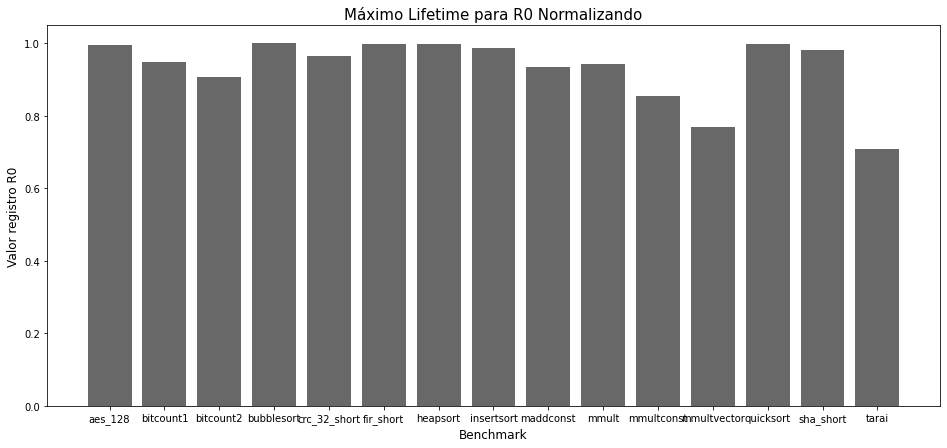

In [ ]:
# Definimos el tamaño de la figura y plotemos el grafico de barras
plt.figure(figsize=(16, 7))
plt.bar(lifetimes_max['bench'],lifetimes_max['r0'], color = palette_gray[6])

# Añadimos los ejes y el título
plt.xlabel('Benchmark', fontsize = 12)
plt.ylabel('Valor registro R0', fontsize = 12)
plt.title('Máximo Lifetime para R0 Normalizando',
          fontsize = 15)

# Mostramos el gráfico
plt.show()

# Análisis Descriptivo

Terminada la primera parte de este fichero, la siguiente se centrará en la obtención de un primer análisis que describan los datos que se tienen. En este, se fijará el foco en observar las relaciones entre las diferentes variable para identificar las más significativas, información relevante para comprender el conjunto, diferencias y similitudes entre los diferentes benchmarks...

Todo ello pensando en uno de los objetivos principales de este trabajo, crear una red o algoritmo que dado un vector de entrada estime la fiabilidad frente a soft errors. Por ello, el estudio de la relación entre la entrada y la salida sera fundamental.

## Correlación de las variables

En primer lugar, se obtendrá un mapa de calor con las correlaciones entre las variables para poder descartar aquellas que no correlen con las tasas de error. Claramente, se deberán descartar para este análisis todas las variables no numéricas.

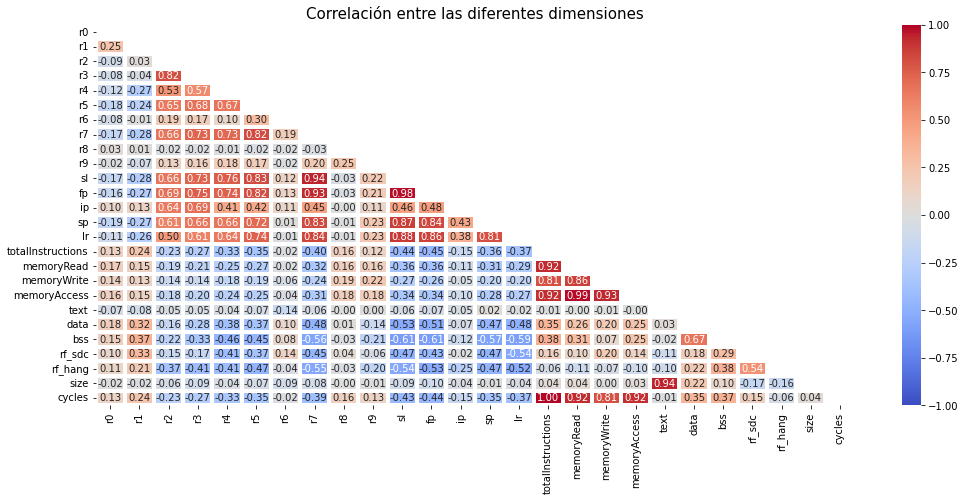

In [ ]:
  # Correlación entre las variables
datos_corr = datos.corr()

# Se realiza el mapa de calor
plt.figure(figsize=(17, 7))

# Dibujo
sns.heatmap(datos_corr, annot=True, fmt='.2f',
            linewidth=3, cmap='coolwarm', mask=np.triu(datos_corr),
            vmin = -1, vmax=1)

# Personalización
plt.yticks(rotation=0)
plt.title('Correlación entre las diferentes dimensiones', fontsize = 15)

plt.show()

Se puede observar que los resultados no son muy alentadores. Tanto la tasa $SDC$ como la tasa $HANG$ mantienen pocas correlaciones con el resto de variables. Esto nos impide eliminar alguna característica actualmente.

Por otro lado, se observa que los registros están bastante correlados entre sí. Esto indica que tienen un comportamiento bastante similar y, por lo tanto, en los siguientes análisis se utilizará el registro $R_0$ como representante del grupo.

## Análisis entre Benchmarks

Como ya se ha podido ver en la limpieza de los valores atípicos, cada benchmark aparenta tener diferentes características respecto a los demás. Por ello, en este apartado se profundizará en el estudio de estas diferencias y sus similitudes.

En primer lugar, es interesante comenzar viendo los individuos que se tienen de cada uno de ellos.

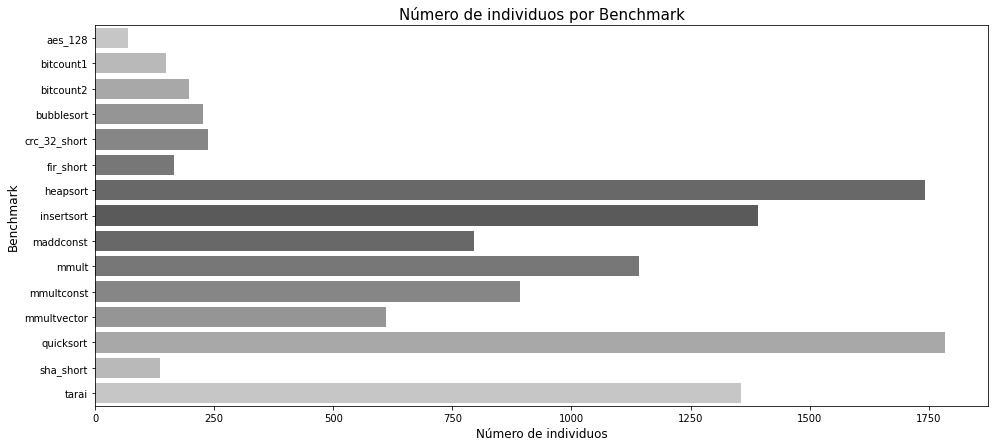

In [ ]:
# Realizamos diagrama de barras
plt.figure(figsize=(16, 7))

# Dibujo
sns.countplot(y='bench', data=datos, palette = palette_gray)

# Personalización
plt.xlabel('Número de individuos', fontsize = 12)
plt.ylabel('Benchmark', fontsize = 12)
plt.title('Número de individuos por Benchmark', fontsize = 15)

plt.show()

Como se puede observar, existe una gran disimilitud entre el número de individuos para cada algoritmo. Ahora bien, veamos algo más detallado que influira a la hora de crear los modelos, el número de accesos a la memoria. Sobretodo, debido a que exite una gran disparidad en esto también.

En el gráfico siguiente, puede verse como hay algoritmos que superan los $10000$ accesos mientras que otros apenas llegan a los $1000$.

In [ ]:
# Media de accesos de memoria
memoryAccess_mean = datos[['bench','memoryAccess']].groupby('bench').mean()
memoryAccess_mean = memoryAccess_mean.reset_index(drop=False)

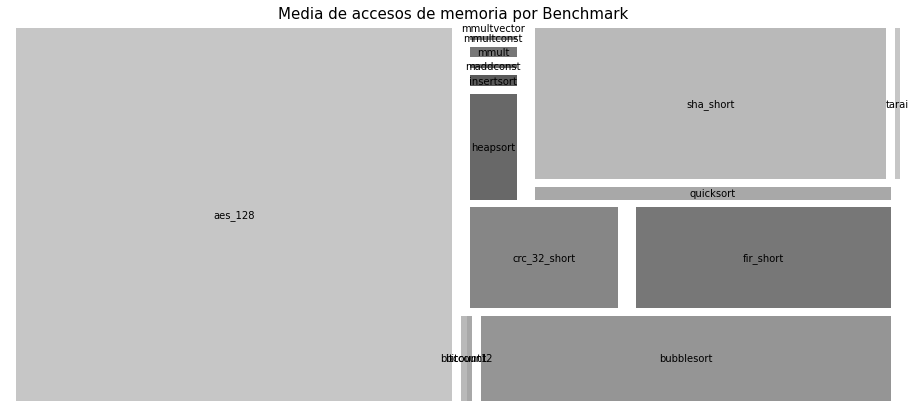

In [ ]:
# Realizamos diagrama de barras
plt.figure(figsize=(16, 7))

# Dibujo
squarify.plot(sizes = memoryAccess_mean['memoryAccess'],
              label=memoryAccess_mean['bench'], color = palette_gray,
              pad = True)

# Personalización
plt.axis('off')
plt.title('Media de accesos de memoria por Benchmark', fontsize = 15)

plt.show()

Aunque esto puede resultar alarmante, realmente no tiene por que suponer un gran problema. Ya que a mayor número de registros también se podría dar un mayor número de soft errors y mantener tasas similares. Esto se puede observar en el siguiente gráfico.

In [ ]:
# Media de accesos de memoria
rf_sdc_mean = datos[['bench','rf_sdc']].groupby('bench').mean()
rf_sdc_mean = rf_sdc_mean.reset_index(drop=False)

rf_hang_mean = datos[['bench','rf_hang']].groupby('bench').mean()
rf_hang_mean = rf_hang_mean.reset_index(drop=False)

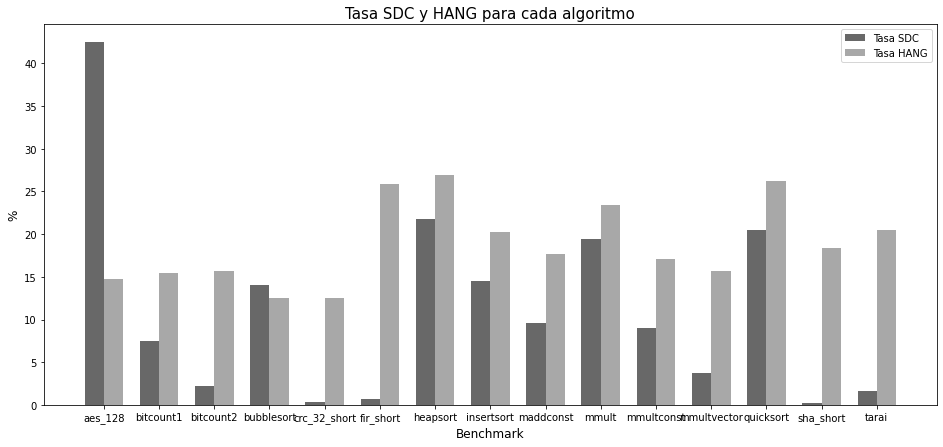

In [ ]:
# Obtenemos las etiquetas, el índice donde se colocarán y el ancho de barras
labels = rf_sdc_mean['bench']
indice_barras = np.arange(15)
ancho_barras = 0.35

# Definimos el tamaño de la figura y plotemos los dos gráficos de barras, uno
# que represente la tasa SDC y el otro que represente la HANG
plt.figure(figsize=(16, 7))
plt.bar(indice_barras - ancho_barras/2, rf_sdc_mean['rf_sdc'], width=ancho_barras,
        label='Tasa SDC', color = palette_gray[6])
plt.bar(indice_barras + ancho_barras/2, rf_hang_mean['rf_hang'],
        width=ancho_barras, label='Tasa HANG', color = palette_gray[2])

# Añadimos la leyenda, los ejes y el título
plt.legend(loc='best')
plt.xlabel('Benchmark', fontsize = 12)
plt.ylabel('%', fontsize = 12)
plt.title('Tasa SDC y HANG para cada algoritmo',
          fontsize = 15)

# Personalizamos la posición de las etiquetas para que puedan leerse
# con facilidad y mostramos el gráfico
plt.xticks(list(range(15)), labels)
plt.show()

Facilmente se observa que apenas hay similitudes entre las tasas de los diferentes benchmarks. Esto es una señal de la dificultad que tendrán los modelos de aprendizaje para poder obtener patrones y realizar estimaciones certeras y fiables.

Por último, se analizará el comportamiento de los lifetimes de los registros en cada uno de los benchmarks. Esto es bastante importante, ya que serán estos los que se usarán, principalmente, como variables de entrada de los algoritmos de estimación de la fiabilidad. Destacar que, como se ha mencionado tras ver la correlación, puesto que la mayoría parecen comportarse de forma similiar entre sí. Únicamente se utilizará $R_0$ como el representante de todos.

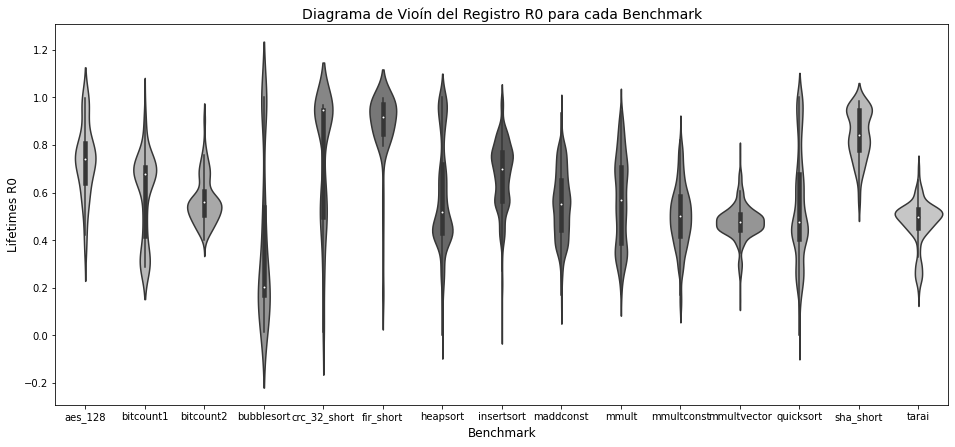

In [ ]:
# Violinplot para cada algoritmo con datos limpios

plt.figure(figsize = (16,7))
sns.violinplot(x='bench', y = 'r0', data = datos, palette = palette_gray)

# Personalización
plt.xlabel('Benchmark', fontsize = 12)
plt.ylabel('Lifetimes R0', fontsize = 12)
plt.title('Diagrama de Vioín del Registro R0 para cada Benchmark',fontsize=14)

plt.show()

# Adecuación datasets modelos

Tras lo visto a lo largo de todo este cuaderno, en este apartado se guardará el dataset que será utilizado en los diferentes modelos del cuaderno **Modelos_Análisis.ipynb**.

Este conjunto de datos no debe guardarse sin más ya que con lo visto en la correlación de las variables, es necesario escoger las características que realmente se utilizarán.

In [ ]:
# Eliminación de características que no se utilizarán
datos.drop(['ind','memoryAccess','text','cycles','totalInstructions'],axis=1,inplace=True)

Tras esto, se guarda para su uso posterior.

In [ ]:
# Se guarda el conjunto
datos.to_csv(route + 'dataset_unido.csv', sep = ';', index = False)